<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Roboflow_EfficientDet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the most up to date version of this notebook, please copy from this link


---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)




# Overview

💡 Recommendation: Open this blog post on [how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555) to continue.

In this notebook we show an example of how to train EfficientDet using a pytorch implementation on a custom dataset that has been uploaded through RoboFlow. The example provides a flexible framework, so you can apply it to your own dataset with a custom number of classes and a different objective. We we tackle chess here. 

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data and Roboflow**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full). Roboflow also hosts many other public datasets and you can easily upload your own custom dataset for your use case, augment, and export in flexible formats. Our tutorial uses Coco Json, but you might have another format (say tfrecord). No problem! Upload your dataset and we will export it in the required format.

### **Model and Training**

For a deep dive on the EfficientDet model please see [the paper](https://arxiv.org/abs/1911.09070). For a shorter look, here is a great [blog post](https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9)! 

We use a pytorch implementation of EfficientDet using the [image detection library](https://github.com/roboflow-ai/Monk_Object_Detection) from Tessellate-Imaging for object detection. Our implementation uses the base version of EfficientDet-d0.  We train from the EfficientNet base backbone, without using a pretrained checkpoint for the detector.

### **Inference**

We witness some fast inference on a few basic examples from our test set to see that our approach is heading in the right direction.

### **Export**

We export our model weights to google drive for future utilization.

### **Next Steps**

We will be exploring evaluation on custom RoboFlow datasets and objectives compared to yoloV3, including training time, inference time, model size, and performance. 

We will also explore comparing performance from the Coco pretrained checkpoint!

## **Stay in touch!**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out to us](roboflow.ai)! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Setting up our envionment

In [1]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 33.52 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.


In [2]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

     |████████████████████████████████| 827.8MB 14kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17453 sha256=02b8de4f90b4f4a9a80dcd652ebb40957a62e45521ac476ddf1ccee0c4eb9536
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml


In [3]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     \ 389kB 11.0MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=0a30bf477e3c44b7d32374b3eda123ec7acb864ad71c824cb042cc6a5f878cac
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvjjayp7/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=602aa6b69200058aaaf0c845c4c34cf90796e1f63a3c6ee5d3b5de01d5c83561
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
     |██████████████████

# Let's get some data! 

The best part about Roboflow is the efficient management of your datasets. [Upload you dataset](roboflow.ai) and you will recieve a fresh curl code to ouput it in whatever augmented and annotated format you need. 

In [4]:
#fresh curl courtesy of roboflow.ai, outputing our dataset in Coco Json format

##THIS CELL NEEDS CHANGED##
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ESmQ7MrKxTxMpIimWwCEHtgB5AA-PcbqZqpiUjItjnEulw?download=1"
!chmod 777 "ESmQ7MrKxTxMpIimWwCEHtgB5AA-PcbqZqpiUjItjnEulw?download=1"
!mv "ESmQ7MrKxTxMpIimWwCEHtgB5AA-PcbqZqpiUjItjnEulw?download=1" PDR_COCO_FORMAT.zip
!unzip PDR_COCO_FORMAT.zip
!rm PDR_COCO_FORMAT.zip

--2020-10-04 03:50:04--  https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ESmQ7MrKxTxMpIimWwCEHtgB5AA-PcbqZqpiUjItjnEulw?download=1
Resolving correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)... 13.107.136.9
Connecting to correoipn-my.sharepoint.com (correoipn-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/PDR_COCO_FORMAT.zip?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2lwbl9teC9FU21RN01yS3hUeE1wSWltV3dDRUh0Z0I1QUEtUGNicVpxcGlVakl0am5FdWx3P3J0aW1lPXJsZ2VsQmhvMkVn [following]
--2020-10-04 03:50:04--  https://correoipn-my.sharepoint.com/personal/ccarrillog1400_alumno_ipn_mx/Documents/Data%20Bases/Other%20Databases/PDR_COCO_FORMAT.zip?originalPath=aHR0cHM6Ly9jb3JyZW9pcG4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvY2NhcnJpbGxvZzE0MDBfYWx1bW5vX2

In [5]:
#let's take a look at our directory
#notice the data came down in train, valid, test, splits - this is pre set during the dataset upload process
%ls

Monk_Object_Detection/  sample_data/  test/  train/  valid/


In [6]:
#let's take a peak in train
#jpg images and some coco json annotations
%ls train

10047_right.jpeg*  21096_left.jpeg*   37332_left.jpeg*
10193_right.jpeg*  21096_right.jpeg*  37332_right.jpeg*
10321_left.jpeg*   21190_right.jpeg*  37813_left.jpeg*
10570_right.jpeg*  21205_left.jpeg*   37829_left.jpeg*
10785_left.jpeg*   21205_right.jpeg*  37849_right.jpeg*
1084_right.jpeg*   21444_left.jpeg*   37951_left.jpeg*
10904_left.jpeg*   21511_left.jpeg*   3802_left.jpeg*
10954_left.jpeg*   217_left.jpeg*     3802_right.jpeg*
10954_right.jpeg*  217_right.jpeg*    38345_left.jpeg*
1099_right.jpeg*   22160_right.jpeg*  38518_left.jpeg*
1138_left.jpeg*    22271_right.jpeg*  38662_left.jpeg*
1138_right.jpeg*   22379_right.jpeg*  38856_left.jpeg*
11417_right.jpeg*  22669_left.jpeg*   39164_left.jpeg*
11492_right.jpeg*  22669_right.jpeg*  39164_right.jpeg*
11730_right.jpeg*  23326_left.jpeg*   39353_right.jpeg*
11854_left.jpeg*   23326_right.jpeg*  39741_left.jpeg*
11854_right.jpeg*  23422_right.jpeg*  40178_right.jpeg*
11896_left.jpeg*   23692_right.jpeg*  40183_left.jpeg*
12108_

In [7]:
#let's take a peek at the annotations
#class categories, and bounding boxes are provided for our train set
#%pycat train/_annotations.coco.json

In [8]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir APEC
!mkdir APEC/annotations
!mkdir APEC/Annotations
!mkdir APEC/Images

In [9]:
%cp train/_annotations.coco.json APEC/annotations/instances_Images.json

In [10]:
%cp train/*.jpeg APEC/Images/

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [11]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [12]:
from train_detector import Detector

In [13]:
gtf = Detector();

In [14]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "APEC";
img_dir = "./";
set_dir = "Images";

In [15]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=16, image_size=512, use_gpu=True, )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [16]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [17]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [ ]:
%%time
gtf.Train(num_epochs=250, model_output_dir="trained/");

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:2179: UserWarning: Exporting aten::index operator with indices of type Byte. Only 1-D indices are supported. In any other case, this will produce an incorrect ONNX graph.
  warnings.warn("Exporting aten::index operator with indices of type Byte. "



Epoch    64: reducing learning rate of group 0 to 1.0000e-05.



Epoch    72: reducing learning rate of group 0 to 1.0000e-06.


# Inference

In [24]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [25]:
from infer_detector import Infer

In [26]:
gtf = Infer();

In [27]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

In [28]:
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [29]:
class_list

['Background', 'NV', 'AR']

In [48]:
%%time
test_images = [f for f in os.listdir('test') if f.endswith('.jpeg')]
import random
img_path = "test/" + random.choice(test_images);
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.034s)
CPU times: user 727 ms, sys: 9.96 ms, total: 737 ms
Wall time: 728 ms


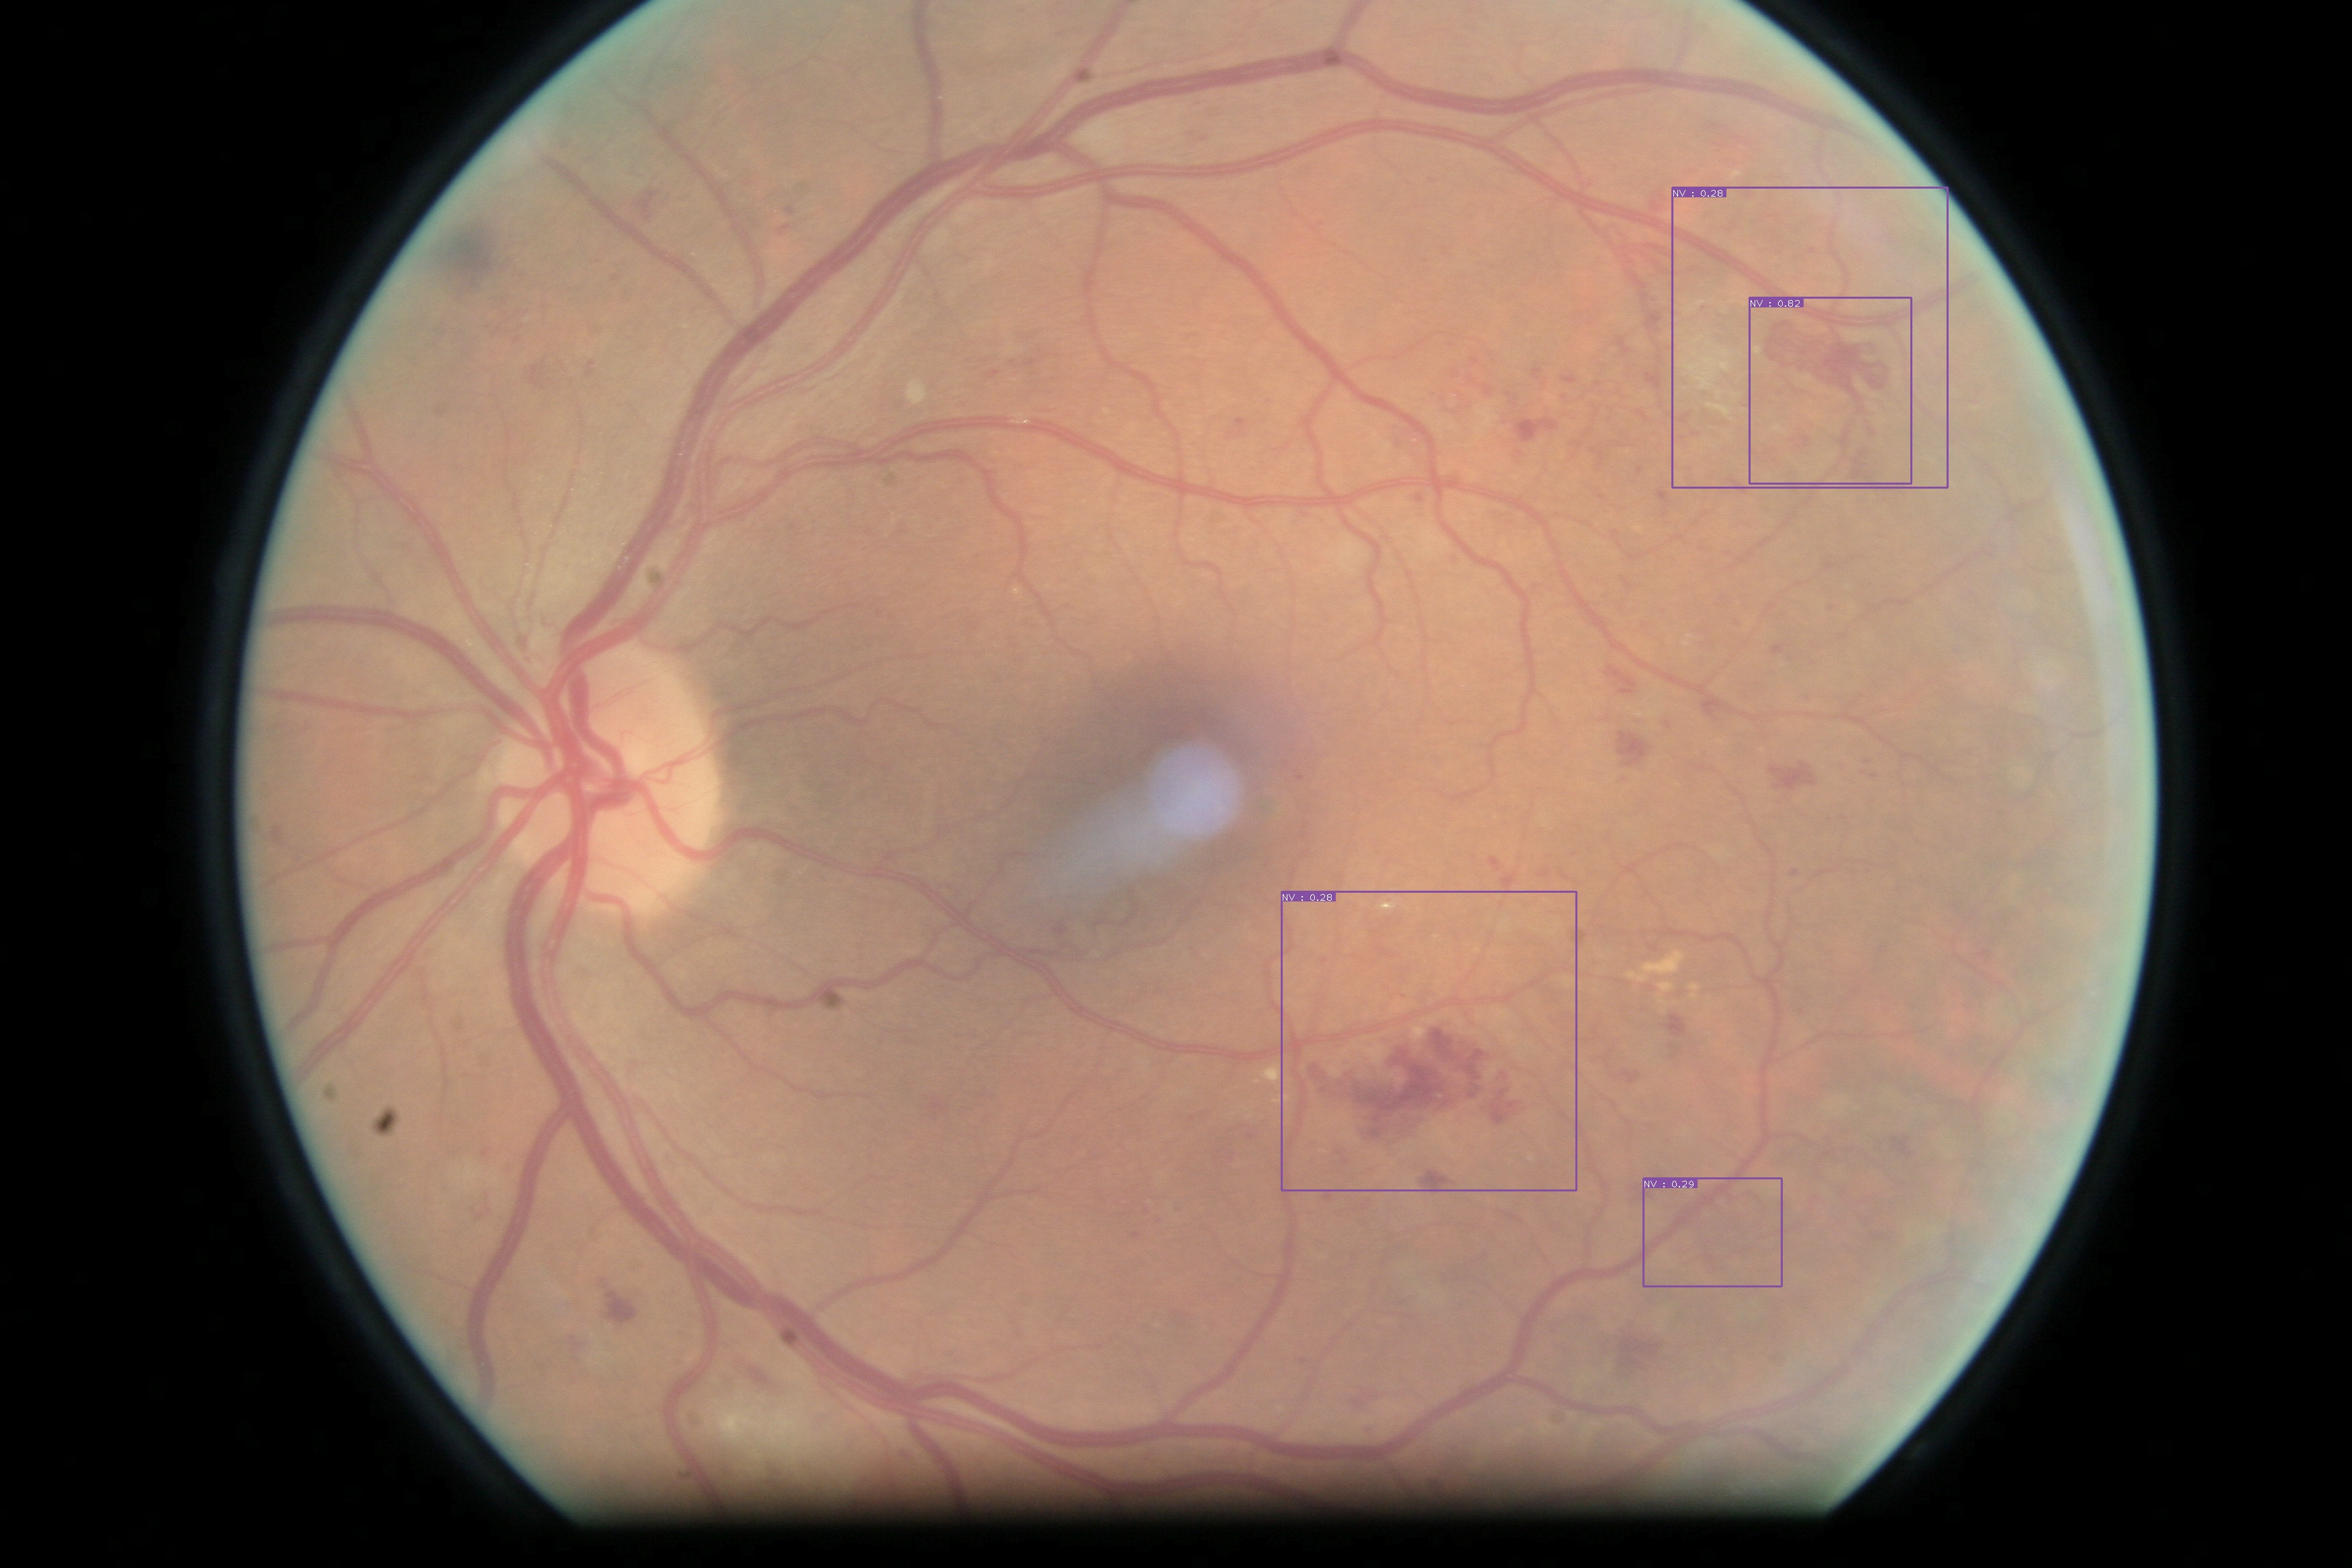

In [49]:
from IPython.display import Image
Image(filename='output.jpg') 

# Export Trained Weights

In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

# Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference


In [ ]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 35.33 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.


In [2]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     |████████████████████████████████| 827.8MB 18kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17453 sha256=915917422c4f5c2a40350105d372c0abe11530dc08febbf0f066a50f341c0a45
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml
     - 337kB 9.2MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=64b0c5bb83b3b0cb9a114968c85e2e6bdcc7e2e8f8093397175567c62480eecb
  Stored in directory: /tmp/pip-ephem-wheel-cache-n4lawy_0/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is inco

In [ ]:
#recover trained weights
!mkdir '/trained'
#note these are old weights that I didn't train for too long
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx' '/trained/signatrix_efficientdet_coco.onnx'
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth' '/trained/signatrix_efficientdet_coco.pth'

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="/trained")

In [ ]:
#download some test data
!curl -L [YOUR LINK HERE] | jar -x

In [ ]:
!ls test

In [ ]:
#extract class list from our annotations
#in your application you will probably already have this saved
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

In [ ]:
%%time
#bang!
img_path = "test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

In [ ]:
from IPython.display import Image
Image(filename='output.jpg') 